In [1]:
import pandas as pd

In [2]:
import os
cur = os.getcwd()
print(cur)

c:\qtri\Purdue\Pengyi Shi\MLAI in healthcare\Generative-AI-and-LLM-in-Healthcare-Operations\Integration


In [3]:
my_csv = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_cap.csv")
myDF_no_capped = pd.read_csv("..\dataset\demographics_to_placement_simulation_WR_no_cap.csv")

## EMployment Status

In [4]:
unknown_employment_index = my_csv[ (my_csv['employmentStatus_Full_Time'] == 0) & (my_csv['employmentStatus_Part_Time'] == 0) & (my_csv['employmentStatus_Unemployed'] == 0)].index

In [5]:
unknown_employment_age = my_csv[ (my_csv['employmentStatus_Part_Time'] == 0) & (my_csv['employmentStatus_Unemployed'] == 0) & (my_csv['employmentStatus_Full_Time'] == 0) ]['age']

In [6]:
unemployment_index = my_csv[ my_csv['employmentStatus_Unemployed'] == 1].index
unknown_employment_index

type1_index = list(unemployment_index) + list(unknown_employment_index)
type2_index = list(my_csv[ my_csv['employmentStatus_Full_Time'] == 1].index) + list(my_csv[ my_csv['employmentStatus_Part_Time'] == 1].index)

In [7]:
new_row = [0] * my_csv.shape[0]
for index in type1_index:
    new_row[index] = 1

my_csv['Employed'] = new_row
my_csv.drop(['employmentStatus_Part_Time', 'employmentStatus_Full_Time'], axis =1, inplace = True )

In [8]:
new_row = [0] * my_csv.shape[0]
for index in type2_index:
    new_row[index] = 1

my_csv['Unemployed'] = new_row
my_csv.drop(['employmentStatus_Unemployed'], axis =1, inplace = True )

In [21]:
my_csv.columns

Index(['age', 'num_previous_recidivisms', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Male', 'registeredSexOffender_TRUE',
       'violentOffender_TRUE', 'gangMember_x_TRUE', 'homeless_TRUE',
       'HighestEducationLevel_High_School_Diploma',
       'HighestEducationLevel_No_HS_Diploma',
       'HighestEducationLevel_Some_College', 'licenseStatus_Not_Suspended',
       'licenseStatus_Suspended', 'c_occu_jail', 'c_occu_wr', 'c_occu_hd',
       'c_vio', 'ocp_jl_low_los', 'ocp_jl_total', 'ocp_wr_low_los',
       'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total', 'placement',
       'Employed', 'Unemployed'],
      dtype='object')

In [23]:
my_csv.drop(['Unemployed', 'ocp_wr_low_los', 'ocp_jl_low_los', 'ocp_hd_low_los','licenseStatus_Not_Suspended','licenseStatus_Suspended'], axis=1, inplace=True) 

## MODEL

In [25]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in my_csv.iterrows():
    if item['placement'] == 'work release':
        my_csv['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        my_csv['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        my_csv['placement'].iat[ind] = '2'

#object to int
my_csv['placement'] = pd.to_numeric(my_csv['placement'])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [27]:
y = my_csv["placement"]
X = my_csv.drop(["placement"], axis = 1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50) 

In [21]:
rf3 = RandomForestClassifier(random_state= 50)
rf3.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [23]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [28]:
#sh = HalvingGridSearchCV(rf3, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [29]:
sh.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 230}

In [51]:
rf2a = RandomForestClassifier(max_depth= 7, max_features = 'sqrt', min_samples_leaf = 2,
 min_samples_split = 2, n_estimators = 230, random_state= 50) #---> 0.81
#rf2a = RandomForestClassifier(max_depth= None, max_features = 'sqrt', min_samples_leaf = 2,
# min_samples_split = 2, n_estimators = 230, random_state= 50) # --> 0.94

In [39]:
#import pickle
#with open('demographic_occupancy_rf.pkl', 'wb') as file:
#    pickle.dump(rf2a, file)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [52]:
rf2a.fit(X_train, y_train) 
y_preda = rf2a.predict(X_test)
from sklearn.metrics import roc_auc_score
print('roc_auc_score: ' + str(roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )))
print('f1_score: ' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

roc_auc_score: 0.9444253887837998
f1_score: 0.792689496828093
precision_score: 0.8244321655859446
recall_score: 0.7953745445562898


## SHAP 

In [32]:
import shap 

In [34]:
explainer1 = shap.TreeExplainer(rf2a)
shap_values1 = explainer1(X_train)

In [45]:
X_train.to_csv('test.csv', index = False)

In [37]:
import pickle
with open('explainer.pkl', 'wb') as file:
    pickle.dump(explainer1, file)

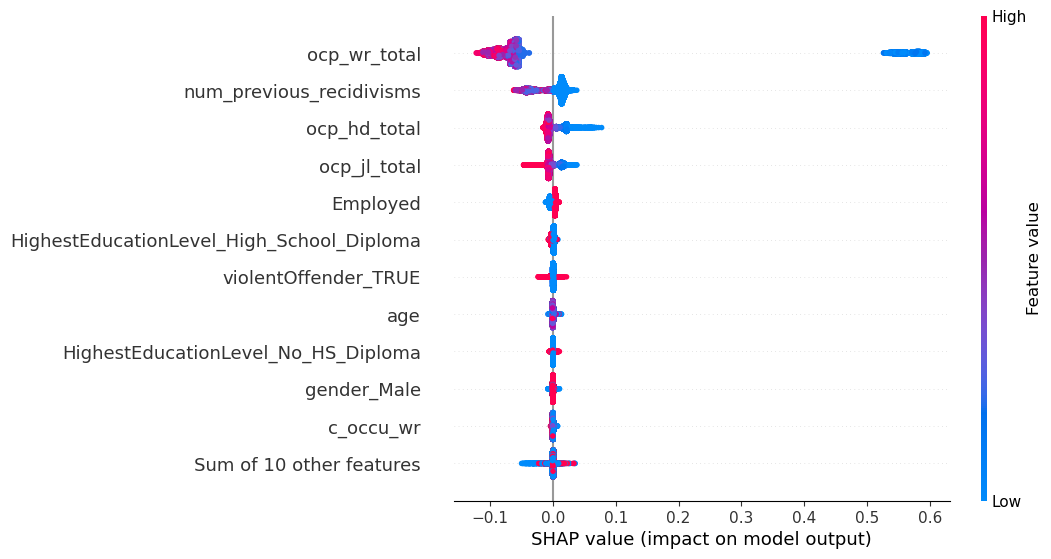

In [44]:
shap.plots.beeswarm(shap_values1[:,:,0], max_display = 12)